In [5]:
import numpy as np, scipy as sp, scipy.stats as stats

from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist

from numpy import exp, log, sqrt
from scipy.special import logsumexp

from rkhsop.tools.rkhsdensity import approximate_expectation, approximate_expectation_1d, density_norm
from rkhsop.op.base import RKHSOperator
from rkhsop.op.cond_probability import CorrectedConditionDensityOperator, ConditionMeanEmbedding, regul
from rkhsop.op.preimg_densest import IsPreimgOp, RmPreimgOp
import rkhsop.kern.base as kern
from rkhsop.kern.base import median_heuristic
import rkhsop.experiments.run as run
from rkhsop.experiments.data import Power, DataPrep, Traffic, Mountain
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as sklkern
from matplotlib.colors import ListedColormap
import calendar
import cde.density_estimator as de
%matplotlib notebook

/home/ischuster/software/python/distributions/distributions/linalg.py:35: UserWarning: warning: caught this exception:module 'numpy.core' has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


In [6]:
from exact_gpytorch import ExactGPModel

In [7]:
realnvp_samples = np.clip(np.load("traffic-realnvp-dow-samples-time-sensor.npy"), -0.1, 1.1)
#realnvp_samples = np.load("traffic-realnvp-dow-samples-time-sensor.npy")
#realnvp_samples = np.load("/home/teamshare/Zalando_Research/traffic/ingmar-2000.npy")

In [117]:
f = lambda x: np.sin(x)
test_x = np.random.randn(100)*5

test_ls = de.LSConditionalDensityEstimation(**{'bandwidth': 1, 'n_centers': 500, 'regularization': 0.1})
test_ls.fit(test_x[:, None], (f(test_x) + np.random.randn(len(test_x)))[:, None])

In [118]:
test_samps = test_ls.sample(np.array([[0]]*2000))
test_samps[1].mean(), test_samps[1].std()

(0.04712823309261498, 1.2829402770167686)

In [119]:
test_m,test_s = test_ls.mean_std(np.array([[0]]))

print(test_m, test_s, "EXPECTED", f(0))

(1, 100) (100, 1) (1, 1)
[[0.02182049]] [[1.29278575]] EXPECTED 0.0


In [8]:
idx = 0
inp_bandwidth = 0.5
op = "cdo"
plot = 'full'
plot = 'mean_sd'
samps_per_timepoint = 1
only_cov = True
dimslice = slice(2, 3)
dimslice_large = slice(1, 3)

In [9]:
test_d = np.array([[0,0],[1,0],[2,0]])
test_l = 2
kern.SKlKernel(sklkern.RBF(test_l)).gram(test_d) / kern.GaussianKernel(test_l).gram(test_d)

array([[25.13274123, 25.13274123, 25.13274123],
       [25.13274123, 25.13274123, 25.13274123],
       [25.13274123, 25.13274123, 25.13274123]])

In [10]:
if False:
    #median_heuristic(train_inp, lambda x: pdist(x, "euclidean"), True)
    #[kern.SKlKernel(sklkern.RBF(k._sd)).gram(d)/k.gram(d) for k in inp_kern.kernels]
    #print(.gram(test_d, test_d))
    skk = kern.SplitDimsKernel([0, 1, 2], [kern.SKlKernel(sklkern.RBF(ls/2)) for ls in median_heuristic(train_inp, lambda x: pdist(x, "euclidean"), True)])
    gk = kern.SplitDimsKernel([0, 1, 2], [kern.GaussianKernel(ls/2) for ls in median_heuristic(train_inp, lambda x: pdist(x, "euclidean"), True)], '*', [1./0.39894228, 1])

    print(gk.gram(test_d) / skk.gram(test_d))


In [11]:
traf = Traffic()
traf.data['train'] = Traffic.equalize_smp_size(traf.data['train'])
traf.data['test'] = traf.data['test']

(train_inp, train_out) = Traffic.stackup_smp(traf.data['train'])

train_out = train_out[:,dimslice, slice(0, 30)]
# assert()
if only_cov:
    (test_inp, test_out) = (traf.data['test'][['DoW', 'Sec of Day']].values, traf.data['test'].values[:, dimslice])

    #inp_kern = kern.SplitDimsKernel([0, 1, 2], [kern.SKlKernel(sklkern.ExpSineSquared(length_scale = 1, periodicity=7)), # weekly period
    #                                            kern.SKlKernel(sklkern.ExpSineSquared(length_scale = 1, periodicity=24 * 60 * 60))]) # daily period
    #inp_kern = kern.SplitDimsKernel([0, 1, 2], [kern.SKlKernel(sklkern.RBF(1)), kern.SKlKernel(sklkern.RBF(60*60))])
    inp_kern = kern.SplitDimsKernel([0, 1, 2], [kern.SKlKernel(sklkern.RBF(ls/2)) for ls in median_heuristic(train_inp, lambda x: pdist(x, "euclidean"), True)])
    #inp_kern = kern.SplitDimsKernel([0, 1, 2], [kern.GaussianKernel(ls/2) for ls in median_heuristic(train_inp, lambda x: pdist(x, "euclidean"), True)], '*', [1./0.39894228, 1])
    inp_kern = kern.SplitDimsKernel([0, 1, 2], [kern.LaplaceKernel(np.sqrt(ls)/4) for ls in median_heuristic(train_inp, lambda x: pdist(x, "euclidean"), True)])
else:
    (train_inp, train_out) = DataPrep.prepare_markov_1st(train_inp, train_out)
    (test_inp, test_out) = DataPrep.prepare_markov_1st(traf.data['test'][['DoW', 'Sec of Day']].values, traf.data['test'].values[:, dimslice])
    inp_kern = kern.SplitDimsKernel([0, 1, 2], [kern.SKlKernel(#sklkern.ExpSineSquared(length_scale = 1, periodicity=60) + # minute
                                                               sklkern.ExpSineSquared(length_scale = 1, periodicity=60 * 60) + # hour
                                                               sklkern.ExpSineSquared(length_scale = 1, periodicity=60 * 60 * 24) + # day
                                                               sklkern.ExpSineSquared(length_scale = 1, periodicity=60 * 60 * 24 * 7) #+ # week
                                                               #sklkern.ExpSineSquared(length_scale = 1, periodicity=60 * 24 * 30.41)  # month
                                                              ),
                                           kern.SKlKernel(sklkern.RBF(1))])
    # inp_kern = kern.SKlKernel(sklkern.RBF(1))

for v in [ train_inp, test_inp, train_out, test_out]:
    print(v.shape, end = '')
print()
t_min = train_out.min()
t_max = train_out.max()
lee = np.abs(t_max - t_min)/10.
L_samp = np.linspace(t_min - lee, t_max + lee, len(train_out)).reshape(-1, 1)


#out_kern = kern.GaussianKernel(np.abs(L_samp[0] - L_samp[1]) * 5) # orig
out_kern = kern.GaussianKernel(np.abs(L_samp[0] - L_samp[1]))
#out_kern = kern.GaussianKernel(median_heuristic(train_out.reshape(-1, 1), lambda x: pdist(x, "euclidean"), False) / 2)
if op == 'cdo':
    r = regul(len(train_inp), len(L_samp), a = 0.49, b = 0.49, c = 0.9)
    cdo = CorrectedConditionDensityOperator(train_inp, train_out, L_samp,
                                            inp_kern, out_kern,
                                            inp_regul=r, outp_regul=r)
elif op == 'cmo':
    cdo = ConditionMeanEmbedding(train_inp, train_out,
                                 inp_kern, out_kern,
                                 inp_regul=0.001)
else:
    assert('operator "'+str(op)+'" unknown')
print("Used", len(train_out), "samples for training", len(test_out), "for testing")

1008
(1008, 2)(24912, 2)(1008, 1, 30)(24912, 1)
Used 1008 samples for training 24912 for testing


In [136]:
from conditional_flow import CondFlow
traf = Traffic()
traf.data['train'] = Traffic.equalize_smp_size(traf.data['train'])
traf.data['test'] = traf.data['test']

(train_inp, train_out) = Traffic.stackup_smp(traf.data['train'])

train_out = np.swapaxes(train_out[:,dimslice_large, slice(0, 30)],1,2)
train_inp_cf = train_inp.repeat(train_out.shape[1], 0)
train_out_cf = train_out.reshape(-1,train_out.shape[-1])

train_inp_cf_mean = train_inp_cf.mean(0, keepdims = True)
train_inp_cf_sd = train_inp_cf.std(0, keepdims = True)
train_inp_cf_max = train_inp_cf.max(0, keepdims = True)
train_inp_cf_min = train_inp_cf.min(0, keepdims = True)

1008


In [46]:
train_out.shape

(1008, 30, 2)

In [21]:
cf_maf = CondFlow.optimized_cde(train_inp_cf, train_out_cf, num_hidden=128, num_layers=5, batch_size=1008, epochs=50, learning_rate=1e-5, flow_type="maf")
cf_maf.fit(learning_rate=5e-7, epochs=50)

Constructing dataset
fitting
  0 -3292.6616
  1 -3519.65
  2 -3293.523
  3 -3452.3916
  4 -3557.3772
  5 -3295.9001
  6 -3421.8486
  7 -3456.2131
  8 -3533.7578
  9 -3334.5977
 10 -3538.0283
 11 -3506.649
 12 -3483.8904
 13 -3476.7944
 14 -3677.5093
 15 -3723.6577
 16 -3461.1838
 17 -3703.0444
 18 -3571.3037
 19 -3628.911
 20 -3582.1807
 21 -3634.4297
 22 -3800.667
 23 -3863.23
 24 -3844.291
 25 -4042.6199
 26 -3924.4844
 27 -3892.2688
 28 -3742.4458
 29 -4180.6953
 30 -3863.6606
 31 -3962.3384
 32 -4171.1826
 33 -3803.853
 34 -3898.3345
 35 -3815.0505
 36 -3829.1387
 37 -4226.453
 38 -4116.9326
 39 -4071.2144
 40 -4288.0186
 41 -4272.176
 42 -3894.8242
 43 -4194.602
 44 -4108.1475
 45 -4215.976
 46 -4129.0107
 47 -4124.448
 48 -4203.933
 49 -4075.728
  0 -4342.668
  1 -4308.8145
  2 -4147.959
  3 -4169.7344
  4 -4241.805
  5 -4240.878
  6 -4220.726
  7 -4346.7925
  8 -3993.4453
  9 -4251.243
 10 -4161.125
 11 -4170.707
 12 -4134.9297
 13 -4100.22
 14 -4179.211
 15 -4236.7393
 16 -4236

In [22]:
cf_rnvp = CondFlow.optimized_cde(train_inp_cf, train_out_cf, num_hidden=128, num_layers=5, batch_size=1008, epochs=50, learning_rate=5e-5, flow_type="rnvp")
cf_rnvp.fit(learning_rate=5e-7, epochs=50)

Constructing dataset
fitting
  0 16967956.0
  1 1228525.5
  2 88812.42
  3 12010.695
  4 11389.278
  5 15170.129
  6 16632.42
  7 16547.021
  8 16226.085
  9 8366.436
 10 12293.36
 11 16618.75
 12 15256.172
 13 12349.389
 14 14975.703
 15 10548.662
 16 13027.145
 17 16078.414
 18 16941.613
 19 12744.977
 20 15878.9795
 21 12398.755
 22 15503.723
 23 20391.719
 24 19223.27
 25 18445.645
 26 18040.234
 27 14919.608
 28 16570.266
 29 17013.072
 30 16121.996
 31 16934.02
 32 15197.369
 33 7461.1016
 34 18350.77
 35 16823.182
 36 14720.841
 37 10744.543
 38 12330.02
 39 19317.895
 40 21301.385
 41 20242.135
 42 19872.041
 43 18837.951
 44 18690.062
 45 18610.598
 46 16539.314
 47 15526.489
 48 18116.21
 49 17328.557
  0 16846.656
  1 16222.965
  2 15275.836
  3 13812.063
  4 13433.553
  5 13232.932
  6 12757.209
  7 11941.37
  8 7405.9404
  9 7404.0537
 10 7632.003
 11 6989.4727
 12 6557.0977
 13 6353.5596
 14 6436.2295
 15 6342.086
 16 6250.8345
 17 6079.664
 18 6239.282
 19 5903.092
 20 5

In [23]:
if False:
    #this returns absolute crap predictions - because we would need a heteroscedastic output model
    import torch
    egp = ExactGPModel.optimized_gp(train_inp_cf.sum(1), train_out_cf[:,1], epochs=200, grid_size_ratio=0.5) #doesn't work for sheer 
    pred = egp(torch.tensor(np.sum(train_inp, axis=1, keepdims=True).astype(np.float), dtype=torch.float))
    out_mean_gp, out_sd_gp = pred.mean.detach().numpy(), torch.diag(pred.covariance_matrix).detach().numpy()
    plt.plot(out_mean_gp)    

In [24]:
nsamps_flow = 2000
out_mean_maf, out_sd_maf = np.empty_like(train_inp), np.empty_like(train_inp)
out_mean_rnvp, out_sd_rnvp = np.empty_like(train_inp), np.empty_like(train_inp)
for i, point in enumerate(train_inp):
    samps = cf_maf.sample(nsamps_flow, point).cpu().detach().numpy()
    out_mean_maf[i,:], out_sd_maf[i,:] = samps.mean(0), samps.std(0)
    samps = cf_rnvp.sample(nsamps_flow, point).cpu().detach().numpy()
    out_mean_rnvp[i,:], out_sd_rnvp[i,:] = samps.mean(0), samps.std(0)

In [26]:
lh = cdo.lhood(test_inp, test_out, diag=True)

In [27]:
isposl = (lh>0).flatten()
logabsl = np.log(np.abs(lh)).flatten()
possum = logabsl[isposl].sum()
negsum = logabsl[isposl == False].sum()
overall_llhood = logsumexp([possum, negsum],b=[1,-1])
lh.shape

(24912,)

In [28]:
logsumexp(logabsl, b = np.sign(lh)) - log(lh.size) # log average test likelihood

2.945992142885057

1008
1008


<IPython.core.display.Javascript object>


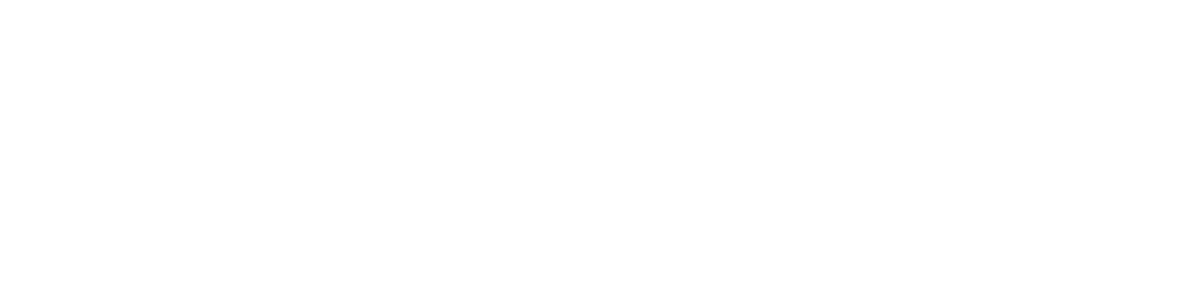

In [29]:
traf.plot(dow=[0,1], sensor=3, bins=[144,60], filename='Hist2d_MonSun_sensor3.png')

In [30]:
if only_cov:
    (test_inp, test_out) = Traffic.stackup_smp(Traffic.equalize_smp_size(traf.data['train']))
test_out_mean = test_out.mean(-1)[:, dimslice].squeeze()
test_out_var = test_out.var(-1)[:, dimslice].squeeze()
cdo_mean_var = cdo.mean_var(test_inp)

1008
(1008, 1) (1008, 1008) (1008, 1)
5.518704583307551e-07 [[5.13405530e-05]
 [2.67289972e-05]
 [3.90104621e-05]
 ...
 [4.17284122e-05]
 [4.00199060e-05]
 [3.90747813e-05]]


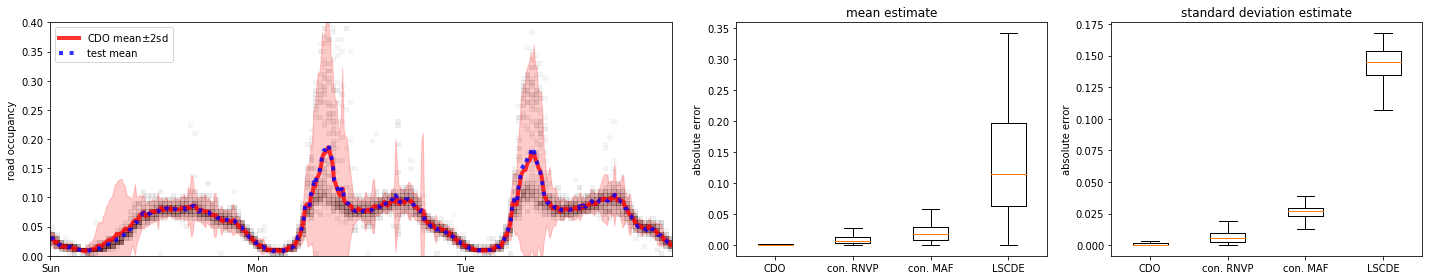

In [139]:
def plot_traffic_timeseries(res, figsize = np.array((20, 4))):
    cm =  ListedColormap(np.vstack([np.zeros((3,1000)), np.linspace(0.,1,1000)[:,None].T]).T)
    lim = [0, res["test_mean_y"].size]
    
    fig, (cdo_ax, flow_ax) = plt.subplots(1, 2, sharex=True, sharey=True, figsize = figsize)
    for [name, ax] in (["cdo", cdo_ax], ["rnvp", flow_ax]):
        (m, sd) = (res[name+"_m"], res[name+"_sd"])
        ax.hist2d(res["test_x"], res["test_y"], bins=[144,60],  cmap=cm, range = [[0, test_out.shape[0]], [0, 0.4]])
        ax.plot(np.arange(lim[1]), res[name+"_m"], "r-", alpha = 0.5)
        ax.fill_between(np.arange(lim[1]), (m + 2 * sd).flatten(), (m - 2 * sd).flatten(), color='r', alpha=0.1)
        ax.set_ylabel("road occupancy")
        ax.set_xticks(range(0, 1008, 144))
        ax.set_xticklabels([calendar.day_abbr[i] for i in (np.arange(7)+6)%7])
        ax.plot(np.arange(lim[1]), res["test_mean_y"], "k:", alpha = 0.9)
        
        
    cdo_ax.set_title("conditional density operator")
    flow_ax.set_title("conditional RealNVP")

    fig.tight_layout()
    fig.savefig("Traffic_CDO_vs_CRNVP.png", dpi = 300)

def plot_traffic_cdo_and_ae(res, ndays = 7, figsize = np.array((20, 4)), relative = False):
    cm =  ListedColormap(np.vstack([np.zeros((3,1000)), np.power(np.linspace(0.,0.8,1000), 0.65)[:,None].T]).T)
    lim = [0, ndays * 144]
    
    if relative:
        ylabel = "scaled absolute error"
        est_add = "_s"
    else:
        ylabel = "absolute error"
        est_add = ""
    
    fig, (cdo_ax, ae_m_ax, ae_v_ax) = plt.subplots(1, 3, sharex=False, sharey=False, figsize = figsize, gridspec_kw={'width_ratios': [2, 1, 1]})
    for [name, ax] in (["cdo", cdo_ax],):
        (m, sd) = (res[name+"_m"], res[name+"_sd"])
        hist_idx = (res["test_x"] < lim[1])
        ax.hist2d(res["test_x"][hist_idx], res["test_y"][hist_idx], bins=[144,60],  cmap=cm, range = [lim, [0, 0.4]])
        ax.plot(np.arange(lim[1]), res[name+"_m"][:lim[1]], "r-", linewidth = 4., alpha = 0.8, label=r"CDO mean±$2$sd")
        ax.fill_between(np.arange(lim[1]), (m + 2 * sd).flatten()[:lim[1]], (m - 2 * sd).flatten()[:lim[1]], color='r', alpha=0.2)
        ax.set_ylabel("road occupancy")
        ax.set_xticks(range(0, lim[1], 144))
        ax.set_xticklabels([calendar.day_abbr[i] for i in (np.arange(ndays)+6)%7])
        ax.plot(np.arange(lim[1]), res["test_mean_y"][:lim[1]], "b:", linewidth = 4., alpha = 0.8, label="test mean")
    #cdo_ax.set_title("CDO prediction")
    cdo_ax.legend(loc='upper left')
    labels = ["CDO", "con. RNVP", "con. MAF", "LSCDE"]
    ae_m_ax.boxplot(np.vstack([traffic_plots["cdo_ae_m" + est_add], traffic_plots["rnvp_ae_m" + est_add], traffic_plots["maf_ae_m" + est_add], traffic_plots["lscde_ae_m" + est_add]]).T, showfliers=False, labels=labels)
    ae_m_ax.set_title('mean estimate')
    ae_v_ax.boxplot(np.vstack([traffic_plots["cdo_ae_sd" + est_add], traffic_plots["rnvp_ae_sd" + est_add], traffic_plots["maf_ae_sd" + est_add], traffic_plots["lscde_ae_sd" + est_add]]).T, showfliers=False, labels=labels) 
    ae_v_ax.set_title('standard deviation estimate')
    for ax in [ae_m_ax, ae_v_ax]:
        ax.set_ylabel(ylabel)
    

    fig.tight_layout()
    fig.savefig("Traffic_cdo_and_ae.png", dpi = 300)
    fig.savefig("Traffic_cdo_and_ae.pdf", dpi = 300)
plot_traffic_cdo_and_ae(traffic_plots, ndays = 3)

In [137]:
#Rescale the data for LSCDE. Without rescaling, the data could not be fitted at all
def inp_rescale(inp):
    #Min-max-scaling
    return (inp - train_inp_cf_min) / (train_inp_cf_max - train_inp_cf_min)

    #Z-Score normalization did not work so well
    #return (inp - train_inp_cf_mean)/train_inp_cf_sd * 2

lscde = de.LSConditionalDensityEstimation(bandwidth = 0.1, regularization = 0.1, n_centers = 1000) # parameters from CV with 5k points
perm = np.random.permutation(train_inp_cf.shape[0])[:10000]
lscde.fit(inp_rescale(train_inp_cf), train_out_cf[:, :1])
lscde_mean, lscde_std = lscde.mean_std(inp_rescale(test_inp))

(1008, 1000) (1000, 1) (1008, 1)


In [ ]:
traffic_plots = {"test_x":np.repeat(np.arange(test_out.shape[0]), test_out.shape[2], 0),
                 "test_y":test_out[:,dimslice,:].flatten(),
                 "test_mean_y":test_out_mean}
x = np.hstack([np.repeat(np.arange(7), 144)[:, None], np.tile(np.arange(144), 7)[:, None]])
dark_greys = ListedColormap(np.vstack([np.zeros((3,1000)), np.linspace(0.,1,1000)[:,None].T]).T)
cm = dark_greys # "Greys"
%matplotlib inline
x = test_inp
lim = [0, x.shape[0]]
L_test = np.linspace(t_min, 0.15 , len(train_out)).reshape(-1, 1)

if plot == 'full':
    dens_eval = cdo.lhood(x, L_test)
    rnge = max(np.abs(dens_eval.min()), np.abs(dens_eval.max()))
    cdo_ax.imshow(dens_eval, origin = 'lower', cmap='RdBu',
                extent = (lim[0], lim[1], L_test.min(), L_test.max()),
               vmin = -rnge, vmax = rnge, aspect='auto', alpha = 0.5)
    cdo_ax.colorbar()
    # assert()
    print(dens_eval.min(), dens_eval.mean(), dens_eval.std(), np.sum(dens_eval<0)/dens_eval.size)
else:
    (m, v) = cdo.mean_var(x)
    sd = np.sqrt(np.clip(v, 0, None))
    #sd = np.sqrt(np.abs(v))
    (traffic_plots["cdo_m"], traffic_plots["cdo_sd"]) = (m, sd)
    
    #cdo_ax.title = 'Conditonal density operator'
selection = realnvp_samples[:,:,:,dimslice].squeeze()
realnvp_m = np.hstack(selection.mean(1))
realnvp_var = np.hstack(selection.var(1))
realnvp_sd = np.sqrt(realnvp_var)
(traffic_plots["rnvp_m"], traffic_plots["rnvp_sd"]) = (realnvp_m, realnvp_sd)

#out_mean_maf, out_sd_maf = np.empty_like(train_inp), np.empty_like(train_inp)
#out_mean_rnvp, out_sd_rnvp = np.empty_like(train_inp), np.empty_like(train_inp)

for (name, est, truth) in [("rnvp_ae_m", realnvp_m, test_out_mean),
                           ("maf_ae_m", out_mean_maf[:,1], test_out_mean),
                           ("cdo_ae_m", cdo_mean_var[0].flatten(), test_out_mean),
                           ("lscde_ae_m", lscde_mean.squeeze(), test_out_mean),
                           
                           
                           ("rnvp_ae_v", realnvp_var, test_out_var),
                           ("maf_ae_v", out_sd_maf[:,1]**2, test_out_var),
                           ("cdo_ae_v", cdo_mean_var[1].flatten(), test_out_var),
                           ("lscde_ae_v", lscde_std.squeeze()**2, np.sqrt(test_out_var)),
                           
                           ("rnvp_ae_sd", np.sqrt(realnvp_var), np.sqrt(test_out_var)),
                           ("maf_ae_sd", out_sd_maf[:,1], np.sqrt(test_out_var)),
                           ("cdo_ae_sd", np.sqrt(np.abs(cdo_mean_var[1].flatten())), np.sqrt(test_out_var)),
                           ("lscde_ae_sd", lscde_std.squeeze(), np.sqrt(test_out_var))]:
    ae = np.abs(est - truth)
    rae = np.abs(est/np.abs(truth) - 1)
    traffic_plots[name] = ae
    traffic_plots[name+"_s"] = rae
    print("%s: %.5f(±%.5f)" % (name, ae.mean(), ae.std()))
    print("rel %s: %.5f(±%.5f)" % (name, rae.mean(), rae.std()))
np.save("Traffic_plot_data_aistats", traffic_plots)

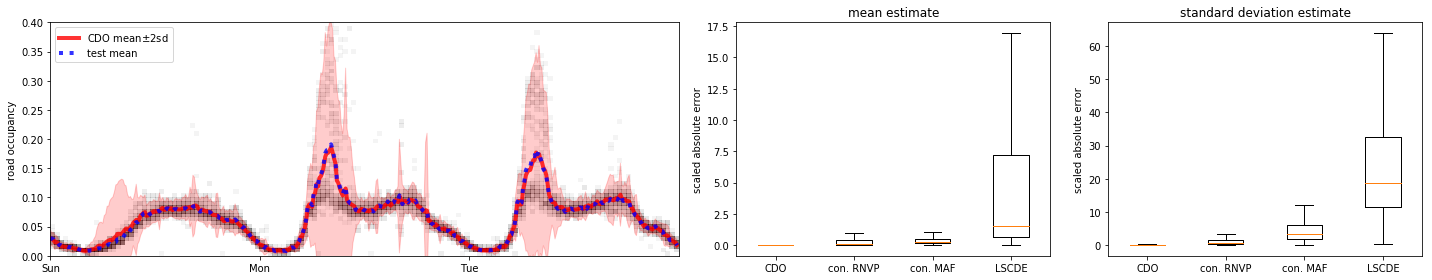

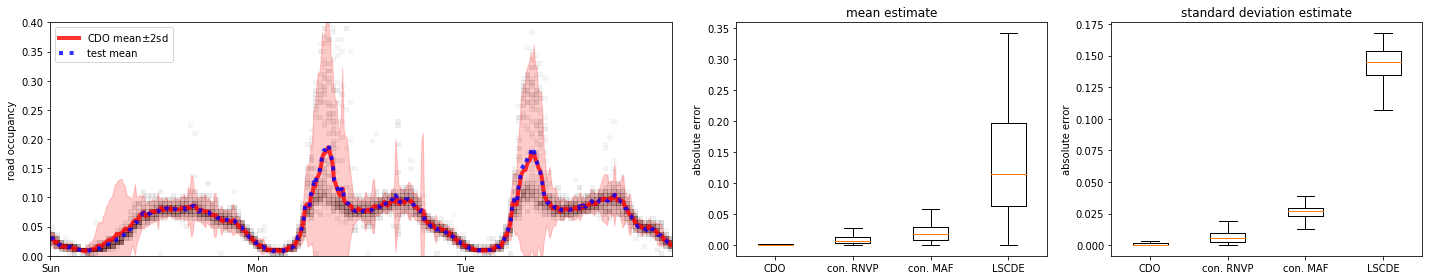

In [142]:
plot_traffic_cdo_and_ae(traffic_plots, ndays = 3, relative=True)
plot_traffic_cdo_and_ae(traffic_plots, ndays = 3, relative=False)

In [65]:
only_cov
traf = Traffic()
traf.data['train'] = Traffic.equalize_smp_size(traf.data['train'])
traf.data['test'] = traf.data['test']

(train_inp, train_out) = Traffic.stackup_smp(traf.data['train'])

train_out = train_out[:,dimslice, slice(0, 30)]
# assert()
if only_cov:
    (test_inp, test_out) = (traf.data['test'][['DoW', 'Sec of Day']].values, traf.data['test'].values[:, dimslice])
test_out.shape

1008


(24912, 1)

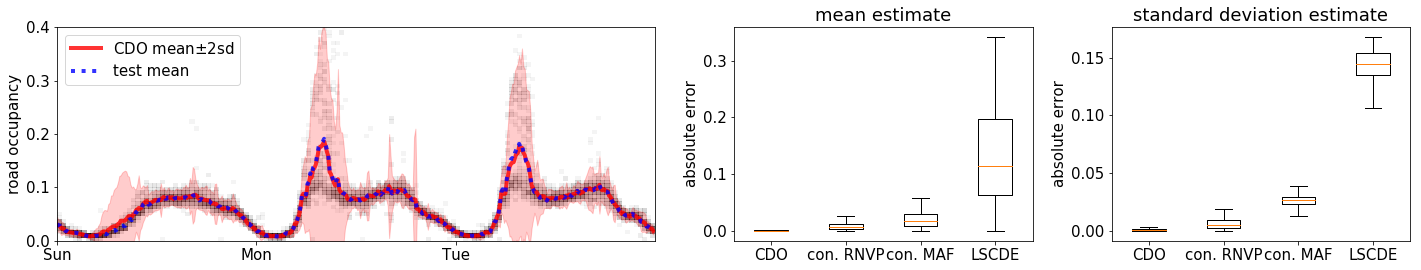

In [143]:
plt.rcParams.update({'font.size': 15})
plot_traffic_cdo_and_ae(traffic_plots, ndays=3)

In [144]:
plt.savefig("Traffic_prediction_AISTATS.pdf")

<Figure size 432x288 with 0 Axes>

In [241]:
x = test_inp#[:10,:]
fact = cdo.get_factors(x)

In [14]:
def mean_absolute_error(x):
    assert(len(x.shape) == 2)
    #assert(x.shape[1] == test_out_mean.size)
    rval =  np.abs(x - test_out_mean[None, :])
    assert(len(rval.shape) == 2)
    assert(rval.shape[0] == x.shape[0])
    assert(rval.shape[1] == test_out_mean.size)
   # print(rval.shape)
    return rval.mean(1, keepdims = 1)

In [15]:
pred_mean = cdo.mean_var(test_inp)


(1008, 1) (1008, 1008) (1008, 1)
5.518704583307551e-07 [[ 8.07293692e-04]
 [ 4.79189044e-04]
 [ 1.93769679e-04]
 ...
 [ 5.63378114e-05]
 [-1.31813657e-05]
 [-1.16780895e-04]]


In [16]:
apr_mean = approximate_expectation(lambda x:x, 1, cdo.outp, density_norm(fact,axis=0), cdo.outp_kern, test_result_size=1, coupled_sampling=False, return_var=True, noise_factor = 0)


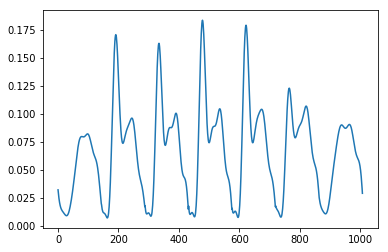

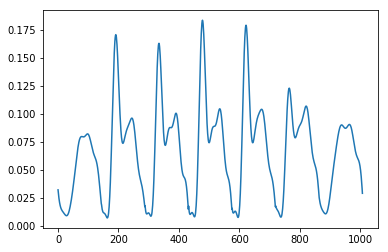

In [17]:
plt.plot(pred_mean[0].squeeze())
plt.figure()
plt.plot(apr_mean[0].squeeze())

In [42]:
%autoreload
assert("The following is too good. have to investigate.")
for snum in [1]*30:
    #np.random.seed(3)
    print(snum)
    #abs_errors_cdo_c, var_c = approximate_expectation(mean_absolute_error, snum, cdo.outp, fact, cdo.outp_kern, test_result_size=1, coupled_sampling=True, return_var=True)
    #print("Coupled", abs_errors_cdo_c.mean(), var_c.mean())
    abs_errors_cdo_d, var_d = approximate_expectation(mean_absolute_error, snum, cdo.outp, (fact), cdo.outp_kern, test_result_size=1, coupled_sampling=False, return_var=True, noise_factor = 1)
    print("Decoupled",  abs_errors_cdo_d.mean(), var_d.mean())

1
Decoupled 0.04700825274784271 0.000589073728805914
1
Decoupled 0.046810723806758374 0.0005748347397675156
1
Decoupled 0.04692759082116419 0.0005893711676015047
1
Decoupled 0.046894576272896386 0.0005863483001972653
1
Decoupled 0.046933695281417484 0.0005865157548651507
1
Decoupled 0.04683888009706629 0.0005807265286445954
1
Decoupled 0.04686799574975227 0.0005877691366402731
1
Decoupled 0.046909290962918467 0.0005860727104218644
1
Decoupled 0.04695045137074573 0.0005933061824833326
1
Decoupled 0.04695144244215595 0.0005875950178252609
1
Decoupled 0.04694771672364663 0.0005818779739848311
1
Decoupled 0.04697357884229485 0.0005869654609618445
1
Decoupled 0.046945391895907004 0.000580703737157389
1
Decoupled 0.046937975477814156 0.0005843296632226686
1
Decoupled 0.04690431049931096 0.0005819008452439364
1
Decoupled 0.046912476968700274 0.0005799163770471183
1
Decoupled 0.04697031120910544 0.0005916210325704297
1
Decoupled 0.046948429781872435 0.0005899738845673948
1
Decoupled 0.04701808

In [286]:
for dow in range(7):
    # x = np.hstack([np.repeat(np.arange(7), 144)[:, None], np.tile(np.arange(144), 7)[:, None]])
    x = np.hstack([np.zeros(144)[:, None] + dow, np.arange(144)[:, None] * traf.measurement_interval_in_sec])
    lim = [0, 144]
    L_test = np.linspace(t_min, 0.15 , len(train_out)).reshape(-1, 1)
    fig, (cdo_ax, flow_ax) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
    if plot == 'full':
        dens_eval = cdo.lhood(x, L_test)
        rnge = max(np.abs(dens_eval.min()), np.abs(dens_eval.max()))
        cdo_ax.imshow(dens_eval, origin = 'lower', cmap='RdBu',
                    extent = (lim[0], lim[1], L_test.min(), L_test.max()),
                   vmin = -rnge, vmax = rnge, aspect='auto', alpha = 0.5)
        cdo_ax.colorbar()
        # assert()
        print(dens_eval.min(), dens_eval.mean(), dens_eval.std(), np.sum(dens_eval<0)/dens_eval.size)
    else:
        (m, v) = cdo.mean_var(x)
        sd = np.sqrt(np.clip(v, 0, None))
        cdo_ax.plot(np.arange(144), m, "b--", alpha = 0.5)
        cdo_ax.fill_between(np.arange(144), m + 2 * sd, m - 2 * sd, color='r', alpha=0.2)
        #cdo_ax.title = 'Conditonal density operator'
    selection = realnvp_samples[dow,:,:,dimslice].squeeze()
    realnvp_m = selection.mean(0)
    realnvp_sd = selection.std(0)
    flow_ax.plot(np.arange(realnvp_m.size), realnvp_m, color='r', alpha=0.2)
    selection.min()
    flow_ax.fill_between(np.arange(realnvp_m.size), realnvp_m + 2 * realnvp_sd, realnvp_m - 2 * realnvp_sd, color='r', alpha=0.2)
    #flow_ax.title = 'RealNVP'

<IPython.core.display.Javascript object>

(1008, 1) (144, 1008) (144, 1)
5.518704583307551e-07 [[ 8.07293692e-04]
 [ 4.79189044e-04]
 [ 1.93769679e-04]
 [-4.35237720e-05]
 [-2.29406927e-04]
 [-3.62764031e-04]
 [-4.44574820e-04]
 [-4.77759956e-04]
 [-4.66953679e-04]
 [-4.18216092e-04]
 [-3.38700272e-04]
 [-2.36290978e-04]
 [-1.19232091e-04]
 [ 4.24072703e-06]
 [ 1.26247166e-04]
 [ 2.39576305e-04]
 [ 3.37956986e-04]
 [ 4.16276404e-04]
 [ 4.70741153e-04]
 [ 4.98977153e-04]
 [ 5.00066960e-04]
 [ 4.74524914e-04]
 [ 4.24212551e-04]
 [ 3.52198606e-04]
 [ 2.62569994e-04]
 [ 1.60202061e-04]
 [ 5.04982982e-05]
 [-6.08887049e-05]
 [-1.68342105e-04]
 [-2.66557882e-04]
 [-3.50800692e-04]
 [-4.17125925e-04]
 [-4.62557084e-04]
 [-4.85210002e-04]
 [-4.84358370e-04]
 [-4.60438408e-04]
 [-4.14993951e-04]
 [-3.50566564e-04]
 [-2.70538266e-04]
 [-1.78936860e-04]
 [-8.02155429e-05]
 [ 2.09805702e-05]
 [ 1.20048242e-04]
 [ 2.12648059e-04]
 [ 2.94903586e-04]
 [ 3.63568569e-04]
 [ 4.16155186e-04]
 [ 4.51018748e-04]
 [ 4.67396822e-04]
 [ 4.65403225e-0

ValueError: Input passed into argument "'y1'"is not 1-dimensional.

<IPython.core.display.Javascript object>

In [169]:
def encode_periodic(data, periods):
    import math
    return torch.cat([torch.cat([torch.sin(data[:,i:i+1]*2*math.pi/p), torch.cos(data[:,i:i+1]*2*math.pi/p)], -1) for i, p in enumerate(periods)], -1)

In [179]:
train_inp_enc = encode_periodic(torch.Tensor(train_inp), train_inp.max(0) + 1)
test_inp_enc = encode_periodic(torch.Tensor(test_inp), train_inp.max(0) + 1)

In [188]:
from conditional_flow import CondRealNVP
train_inp.shape

(1008, 2)

In [189]:
cd = CondRealNVP.optimized_cde(train_inp.repeat(train_out.shape[-1], axis = 0), train_out.reshape(-1,1), epochs = 50, learning_rate=1e-6, weight_decay=1e-6, batch_size=1000, emb_cond_inputs = [([0, 1], 7, 8), ([1,2], 8.58e+04+1, 8)])





  0 -92.63032
  1 -94.153404
  2 -95.66129
  3 -97.15426
  4 -98.63389
  5 -100.10083
  6 -101.5553
  7 -102.9971
  8 -104.426765
  9 -105.84408
 10 -107.24885
 11 -108.64084
 12 -110.02054
 13 -111.38748
 14 -112.74181
 15 -114.08333
 16 -115.41173
 17 -116.72731
 18 -118.02968
 19 -119.318794
 20 -120.594696
 21 -121.857254
 22 -123.10645
 23 -124.342094
 24 -125.56405
 25 -126.772514
 26 -127.96707
 27 -129.14798
 28 -130.31519
 29 -131.4684
 30 -132.60776
 31 -133.73299
 32 -134.84407
 33 -135.94122
 34 -137.02432
 35 -138.09338
 36 -139.14818
 37 -140.18898
 38 -141.21568
 39 -142.22841
 40 -143.22691
 41 -144.21155
 42 -145.18222
 43 -146.13866
 44 -147.08174
 45 -148.01118
 46 -148.92699
 47 -149.82925
 48 -150.71805
 49 -151.59375


In [ ]:
cd.fit(epochs=50, learning_rate=1e-2)

In [210]:
x.repeat(L_test.shape[0], axis = 0)

array([[1.00e+00, 0.00e+00],
       [1.00e+00, 0.00e+00],
       [1.00e+00, 0.00e+00],
       ...,
       [1.00e+00, 8.58e+04],
       [1.00e+00, 8.58e+04],
       [1.00e+00, 8.58e+04]])

In [211]:
lp = cd.log_probs(x.repeat(L_test.shape[0], axis = 0), np.tile(L_test, (x.shape[0], 1)))

In [220]:
lp[:L_test.shape[0]].detach().numpy().flatten() - lp.detach().numpy().reshape( x.shape[0],-1)[0].flatten()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

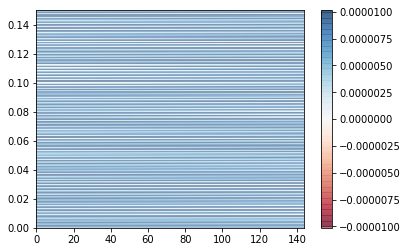

In [221]:
import torch
p = exp((lp - torch.logsumexp(lp,0)).detach().numpy().reshape(-1, x.shape[0]))
rnge = max(np.abs(p.min()), np.abs(p.max()))
plt.imshow(p, origin = 'lower', cmap='RdBu',
            extent = (lim[0], lim[1], L_test.min(), L_test.max()),
           vmin = -rnge, vmax = rnge, aspect='auto', alpha = 0.5)
plt.colorbar()

In [65]:
x.repeat(L_test.shape[0], axis = 0)[:4,:], np.tile(L_test, (x.shape[0], 1))[:4,:]

(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]), array([[0.        ],
        [0.00014896],
        [0.00029791],
        [0.00044687]]))

In [66]:
np.arange(4).reshape(2,2)

array([[0, 1],
       [2, 3]])

In [113]:
nsamp = 100
samples = np.empty((x.shape[0]*nsamp,2))
for i, x_i in enumerate(x):
    idx = slice(i*nsamp,i*nsamp+nsamp)
    samples[idx,0] = x_i[1]
    samples[idx,1] = cd.sample(nsamp, torch.Tensor(x_i)).detach().numpy().flatten()

In [115]:
samples

array([[     0.        , -20010.21484375],
       [     0.        , -19178.9453125 ],
       [     0.        , -19831.96289062],
       ...,
       [ 85800.        ,   5052.36474609],
       [ 85800.        ,   4289.17724609],
       [ 85800.        ,  15494.87109375]])

In [80]:
samples

array([[    0.,    nan],
       [    0.,    nan],
       [    0.,    nan],
       ...,
       [85800.,    nan],
       [85800.,    nan],
       [85800.,    nan]])